# LightGBM

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour, plot_slice
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from model_utils import calc_gini_coef, plot_roc_curve

C:\Users\dan\PycharmProjects\ds\ff_internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from model_utils import split_dataset_v2

# FEATURES_PATH = '../data/features_selected/features_v6_boruta_v1.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_rfe_lgb_v4.csv'

# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc90_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc95_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc98_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc100_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step2_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v1_gain_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v3_gain_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_perc_90_rfe_step5_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_perc_95_rfe_step5_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_perc_98_rfe_step5_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v4_boruta_perc_100_rfe_step2_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_pi_nr10_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_shap_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_perc_100_shap_lgb_v4.csv'

# FEATURES_PATH = '../prod_test/features/features_v4_filtered_v1.csv'
# FEATURES_PATH = '../prod_test/features_v2/features_v2_filtered_v1.csv'
# FEATURES_PATH = '../prod_test/features_v1/features_v1_filtered_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v4_boruta_md5_perc100_iter125.csv'
# FEATURES_PATH = '../prod_test/features/features_v3_boruta_md5_perc100_iter100.csv'
# FEATURES_PATH = '../prod_test/features/features_v3_boruta_perc_100_rfe_step2_lgb_v1.csv'

# FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features_notnull\features_v1_final.csv'

# FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v2_filtered_v1.csv'
# FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v2_boruta_md5_perc100_iter125.csv'
FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v2_final.csv'


X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

## Hyperparameter tuning

### Random search

In [16]:
param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [3, 4, 5],
    'num_leaves': [8, 16, 24, 32],
    'min_child_samples': [30, 50, 100, 200],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 3, 5, 10]
}

In [17]:
model_base = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    class_weight='balanced',
    verbosity=-1,
    random_state=42,
    n_jobs=1,
)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=3
)

random_search.fit(X_train, y_train)

In [19]:
random_search.best_params_

{'subsample': 0.6,
 'reg_lambda': 5,
 'reg_alpha': 1,
 'num_leaves': 24,
 'n_estimators': 800,
 'min_child_samples': 100,
 'max_depth': 4,
 'learning_rate': 0.03,
 'colsample_bytree': 0.5}

### Bayesian Optimization

In [232]:
ALPHA = 0.25  # used for penalizing gap between train and validation score

def objective(trial):

    # params = {
    #     'boosting_type': 'gbdt',
    #     'objective': 'binary',
    #     'metric': 'auc',
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.07),
    #     'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
    #     'max_depth': trial.suggest_int('max_depth', 2, 5),
    #     'num_leaves': trial.suggest_int('num_leaves', 2, 8),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 50, 800),
    #     'subsample': trial.suggest_float('subsample', 0.3, 0.7),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
    #     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    #     'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 10.0),
    #     'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 30.0),
    #     'verbosity': -1,
    #     'class_weight': 'balanced',
    #     'n_jobs': 6,
    #     'random_state': 42
    # }

    # params = {
    #     'boosting_type': 'gbdt',
    #     'objective': 'binary',
    #     'metric': 'auc',
    #     'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
    #     'n_estimators': trial.suggest_int('n_estimators', 600, 1400),
    #     'max_depth': trial.suggest_int('max_depth', 2, 5),
    #     'num_leaves': trial.suggest_int('num_leaves', 3, 6),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 50, 500),
    #     'subsample': trial.suggest_float('subsample', 0.4, 0.6),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
    #     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9),
    #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
    #     'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 6.0),
    #     'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 15.0),
    #     'verbosity': -1,
    #     'class_weight': 'balanced',
    #     'n_jobs': 6,
    #     'random_state': 42
    # }

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1500),
        'max_depth': 3,
        'num_leaves': trial.suggest_int('num_leaves', 2, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9),
        'bagging_freq': 1,
        'reg_alpha': 5.0,
        'reg_lambda': 5.0,
        'verbosity': -1,
        'class_weight': None,
        'n_jobs': 6,
        'random_state': 42
    }

    # Add constraint
    if params['num_leaves'] > 2 ** params['max_depth']:
        raise optuna.TrialPruned()

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)

        y_tr_pred_proba = model.predict_proba(X_tr)[:, 1]
        y_va_pred_proba = model.predict_proba(X_va)[:, 1]

        tr_gini = calc_gini_coef(y_tr, y_tr_pred_proba)
        va_gini = calc_gini_coef(y_va, y_va_pred_proba)

        score = va_gini - ALPHA * (tr_gini - va_gini)
        scores.append(score)

    return np.mean(scores)

In [233]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=250)

[I 2026-01-23 00:10:52,400] A new study created in memory with name: no-name-06f5c1ab-cbe4-443d-8113-5cee58cf02a1
[I 2026-01-23 00:10:56,135] Trial 0 finished with value: 0.5855470498832378 and parameters: {'learning_rate': 0.031236203565420874, 'n_estimators': 1471, 'num_leaves': 4, 'min_child_samples': 200, 'subsample': 0.44680559213273097, 'colsample_bytree': 0.6467983561008608, 'bagging_fraction': 0.42904180608409975}. Best is trial 0 with value: 0.5855470498832378.
[I 2026-01-23 00:10:59,659] Trial 1 finished with value: 0.5815382833372549 and parameters: {'learning_rate': 0.04598528437324806, 'n_estimators': 1261, 'num_leaves': 4, 'min_child_samples': 55, 'subsample': 0.6909729556485982, 'colsample_bytree': 0.8497327922401265, 'bagging_fraction': 0.5061695553391381}. Best is trial 0 with value: 0.5855470498832378.
[I 2026-01-23 00:11:02,043] Trial 2 finished with value: 0.5848375086489084 and parameters: {'learning_rate': 0.02545474901621302, 'n_estimators': 1010, 'num_leaves': 3

In [234]:
print('Best score:', study.best_value)
print('Best params:', study.best_params)

Best score: 0.5920166223277263
Best params: {'learning_rate': 0.029760514249180154, 'n_estimators': 1334, 'num_leaves': 3, 'min_child_samples': 215, 'subsample': 0.6811468445177966, 'colsample_bytree': 0.7892843804904437, 'bagging_fraction': 0.6183540675803015}


In [235]:
plot_optimization_history(study)

In [236]:
plot_parallel_coordinate(study)

In [237]:
plot_contour(study, params=['n_estimators', 'learning_rate'])
# plot_contour(study, params=['max_depth', 'num_leaves'])

In [238]:
plot_slice(study)

In [239]:
plot_param_importances(study)

## Model training and evaluation

In [20]:
# Random search
model = random_search.best_estimator_

In [255]:
# Bayesian optimization
model = lgb.LGBMClassifier(
    **study.best_params,
    boosting_type='gbdt',
    objective='binary',
    importance_type='gain',
    max_depth=3,
    bagging_freq=1,
    reg_alpha=5.0,
    reg_lambda=5.0,
    class_weight=None,
    verbosity=-1,
    n_jobs=6,
    random_state=42,
)

In [3]:
# Bayesian optimization hardcoded
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    importance_type='gain',
    n_estimators=1334,
    learning_rate=0.02976,
    max_depth=3,
    num_leaves=3,
    min_child_samples=215,
    subsample=0.68114,
    colsample_bytree=0.78928,
    bagging_fraction=0.61835,
    bagging_freq=1,
    reg_alpha=5.0,
    reg_lambda=5.0,
    class_weight=None,
    verbosity=-1,
    n_jobs=6,
    random_state=42,
)

In [13]:
model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,3
,max_depth,3
,learning_rate,0.02976
,n_estimators,1334
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,215


In [18]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.6072880663369629


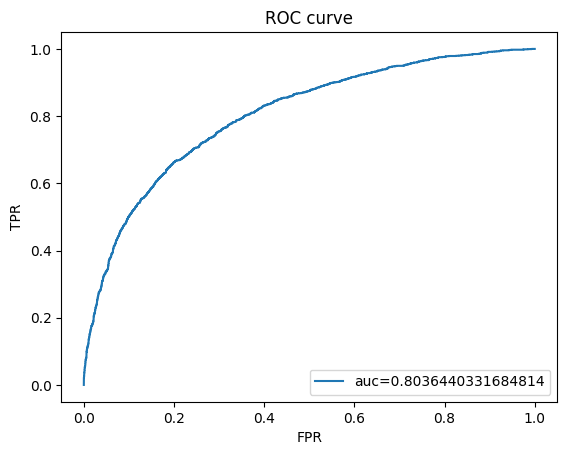

In [19]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

## Feature importance

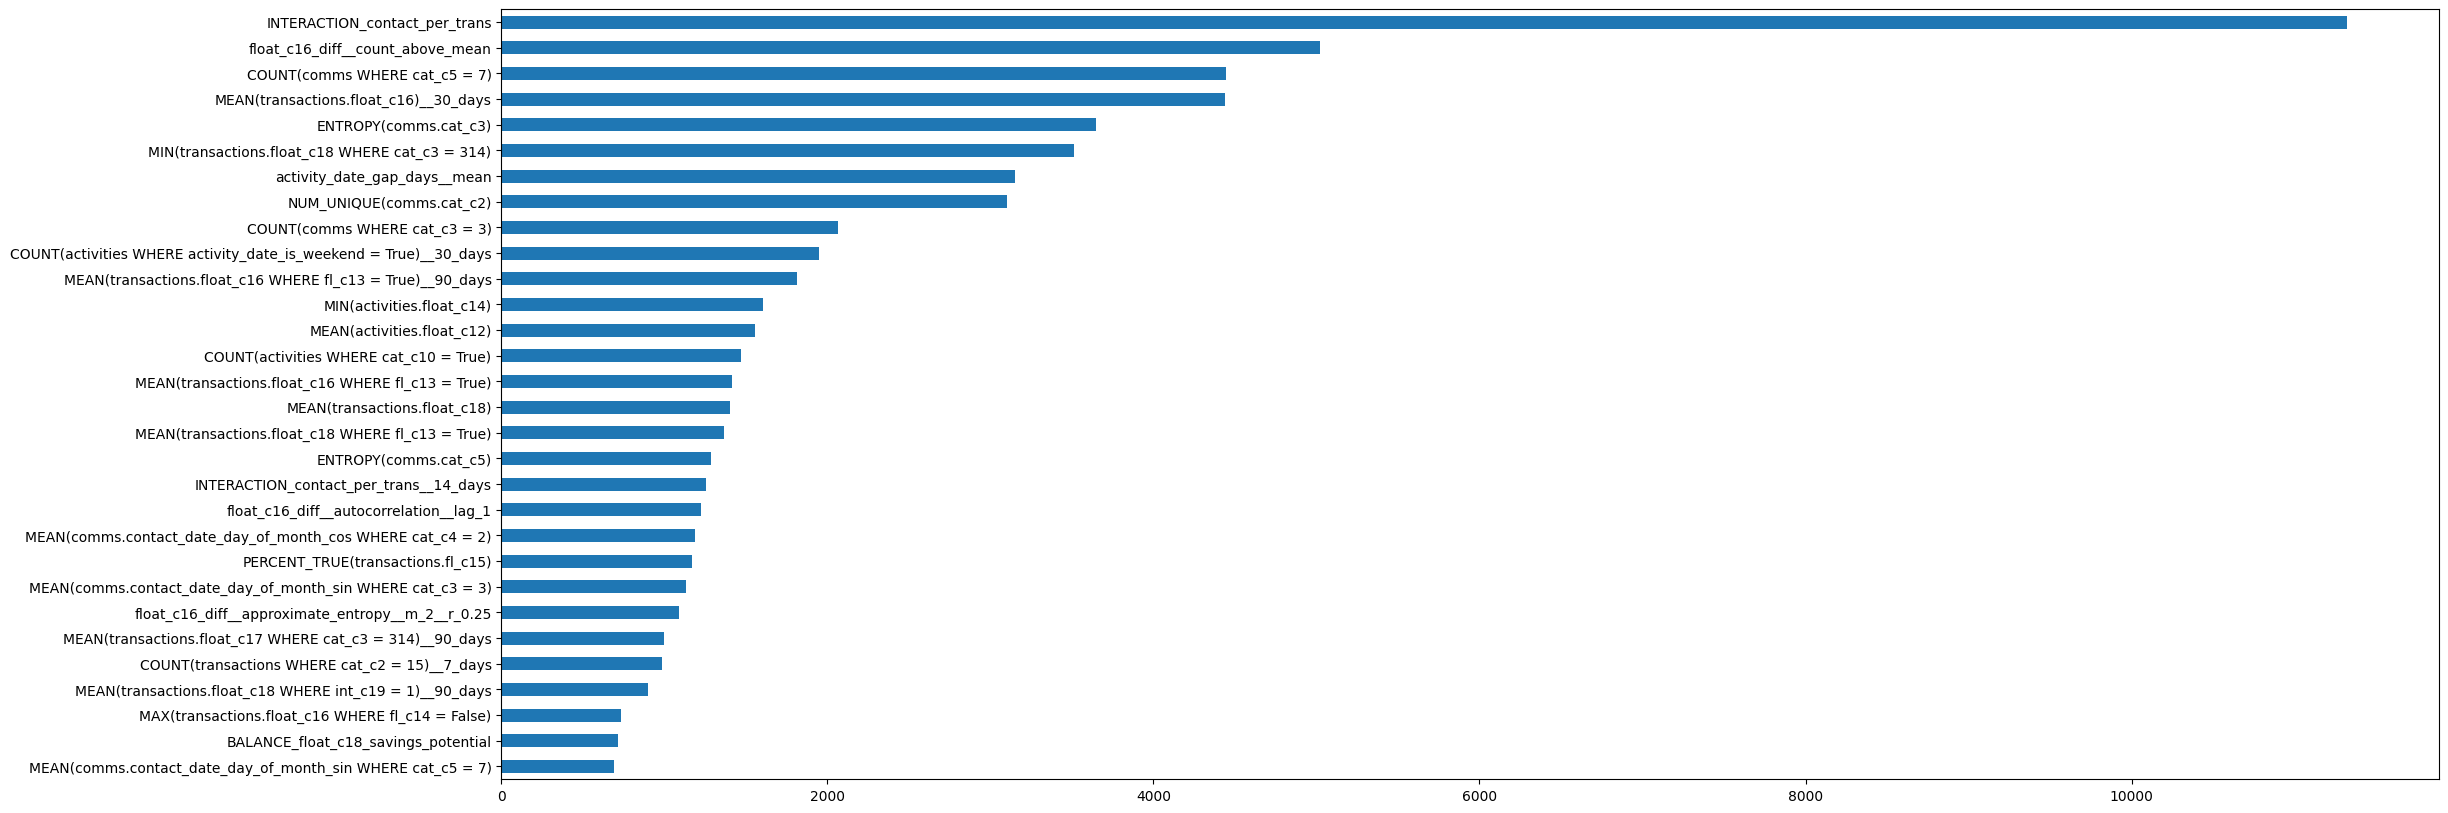

In [69]:
importances = model.booster_.feature_importance(importance_type='gain')
features_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
features_importance.head(30).iloc[::-1].plot(kind='barh', figsize=(25, 10))
plt.show()